<a href="https://colab.research.google.com/github/yueyangu/GANKDE/blob/main/GAN_81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
GOOGLE_DRIVE_PATH ="/content/drive/Shareddrives/_Research Repository - Yueyan Gu/ML for Railroad Track Monitroing/GAN_github"

%cd "{GOOGLE_DRIVE_PATH}"

/content/drive/Shareddrives/_Research Repository - Yueyan Gu/ML for Railroad Track Monitroing/GAN_github


# Preload packages

In [ ]:
%matplotlib inline
import pyximport
pyximport.install()
import tensorflow as tf
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from dataloader import dataloader
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
# from keras.optimizers import adam_v2 as Adam
# from keras.optimizers import gradient_descent_v2 as SGD

from keras.callbacks import TensorBoard
from sklearn.utils import shuffle
from sklearn import preprocessing
#from Preprocessing import *
#from Helper_functions import *
from keras.models import load_model
from sklearn.metrics import recall_score, precision_score, accuracy_score
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks

!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.utils import to_time_series_dataset


     |████████████████████████████████| 793 kB 12.9 MB/s 


# Functions

In [ ]:
def df_normalize(df):
  '''zero-mean normalization of dataframe: conducted by row'''
  df_t=df.T
  for column in df_t.columns:
    df_t[column] = df_t[column] - df_t[column].mean()
  df=df_t.T
  return df

In [ ]:
def ts_kmeans_cluster(X ,filename_out, k, dist_metric='euclidean'):
  '''
  time series clustering based on tslearn
  X: dataframe to be clustered
  filename_out: the filename clustering model to be saved as
  k: number of clusters
  dist_metric: distance metric: “euclidean”, “dtw”, “softdtw” (default: “euclidean”)
  '''
  time_start = time.time()
  km = TimeSeriesKMeans(n_clusters=k, metric=dist_metric, random_state=0, max_iter=50)
  km.fit(X)
  time_end = time.time()
  print('k = {}'.format(k))
  print('time cost:',time_end-time_start,'s')
  # save model
  km.to_hdf5(filename_out)
  print('K_means clustering model saved')
  print('Inertia of this model is {}'.format(km.inertia_))

In [ ]:
def cluster_center_plot(clustermodel, k):
  centroids = []
  for i in range (k):
    plt.plot(clustermodel.cluster_centers_[i], "r-")
    plt.title('Cluster%d' % (i+1))
    plt.show()

In [ ]:
def count_label(y,cluster_num):
  count = np.zeros(cluster_num)
  for label in range(cluster_num):
    for i in range(len(y)):
      if (y[i] == label):
        count[label] += 1
  return count

In [ ]:
def get_generative(G_in, dense_dim=200, out_dim=500, glr=6e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = Adam(lr=glr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

def get_discriminative(D_in, dlr=5e-4, drate=.25, n_channels=16, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)   #################################################################################
    D = Model(D_in, D_out)
    dopt = Adam(lr=dlr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    # print(GAN_in.dtype)
    # print(GAN_in.shape)

    x = G(GAN_in)
    print(x.shape)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

# fixed noise
def sample_data_and_gen(G,fixed_noise,X_train,num_input, noise_dim=561, n_samples=10000):
    XT = X_train
    XN = G.predict(fixed_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((num_input+n_samples, 2))
    y[:num_input,1] = 1      # number of training samples
    y[num_input:,0] = 1   ###############################################################
    X,y = shuffle(X,y)
    return X, y

def sample_noise(G, noise_dim=561, n_samples=10000):
  X = np.random.normal(0, 0.01, size=[n_samples, noise_dim])
  y = np.zeros((n_samples, 2))
  y[:,1] = 1
  return X, y


In [ ]:
from sklearn.metrics import recall_score, precision_score,accuracy_score,f1_score


def train(flag,k,X_train,glr,dlr, epochs,MP, n_samples=10000, noise_dim=50, batch_size=32, verbose=False, v_freq=50,foldernum=1):
    G_in = Input(shape=[noise_dim])
    G, G_out = get_generative(G_in,glr=glr)
    D_in = Input(shape=[noise_dim])
    D, D_out = get_discriminative(D_in,dlr=dlr)
    GAN_in =  Input([noise_dim])   
    GAN, GAN_out = make_gan(GAN_in, G, D)

    d_loss = []
    g_loss = []
    e_range = range(epochs)

    
    #####  fixed noise  (Gaussian)
    num_input = X_train.shape[0]
    fixed_noise = np.random.normal(0, 0.01, size=[num_input, noise_dim])

    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G,fixed_noise,X_train,num_input= num_input, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))

        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        
        if flag:  # if flag ==1 save model at each 50 epochs.  if flag ==0, save the final model only
            if verbose and (epoch + 1) % v_freq == 0:
                print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
                Dfilename="Cluster_Discriminator/{}/MP{}_epoch{}_discriminator_{}.h5".format(foldernum,MP,epoch,k)
                D.save(Dfilename)

    return D,d_loss, g_loss

def train_on_clusters(X_train,glr,dlr,num_cluster,window_length,epochs,foldernum,MP,v_freq):
    for k in range(num_cluster):
        print('Start of Cluster {} GAN training'.format(k+1))
        train_cluster = X_train.loc[X_train['cluster']==k]
        num_train = train_cluster.shape[0]
        print('Number of data points in cluster {} = {}'.format(k, num_train))
        x = train_cluster.iloc[:,:window_length]
        _, d_loss, g_loss = train(1, k, 
                                    x, glr,dlr, epochs, MP, n_samples=num_train, noise_dim=window_length, verbose=True, v_freq=v_freq,foldernum=foldernum)

        # plot d_loss, g_loss
        ax = pd.DataFrame(
            {
                'Generative Loss': g_loss,
                'Discriminative Loss': d_loss,
            }
        ).plot(title='Training loss', logy=True)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        

def evaluate_D_on_clean(X_test, epoch,num_clusters,window_length,foldernum, MP):
  num_anomaly=0
  pred=np.zeros(X_test.shape[0])
  X_test['pred']=pred

  for i in range(num_clusters):
    if (X_test.loc[X_test['cluster']==i].shape[0]):
      model_path = os.path.join('Cluster_Discriminator/','{}/'.format(foldernum),'MP{}_epoch{}_discriminator_{}.h5'.format(MP,epoch,i))
      model = load_model(model_path,compile = False)
      X_test.loc[X_test['cluster']==i,'pred']=np.round(model.predict(X_test.loc[X_test['cluster']==i].iloc[:,:window_length])[:,0])  # [0,1] taken as 0, [1,0] taken as 1
    else:
      print('There is nothing in X_test Cluster {}!'.format(i))
      continue      
  num_anomaly=count_label(X_test['pred'],2)[1]  # the total number of 1 in X_test['pred']
  return num_anomaly

def train_and_evaluate_D_on_clean(flag,X_train,X_test,glr,dlr,num_cluster,window_length,epochs, MP):
    num_anomaly=0
    pred=np.zeros(X_test.shape[0])
    X_test['pred']=pred
    for k in range(num_cluster):
        if (X_test.loc[X_test['cluster']==k].shape[0]):
            D, d_loss, g_loss = train(flag, k, 
                                        X_train.loc[X_train['cluster']==k].iloc[:,:window_length], glr, dlr, epochs,MP,
                                         noise_dim=window_length, verbose=True, 
                                         n_samples=X_train.loc[X_train['cluster']==k].shape[0], v_freq=50)
            X_test.loc[X_test['cluster']==k,'pred']=np.round(D.predict(X_test.loc[X_test['cluster']==k].iloc[:,:window_length])[:,0])  # [0,1] taken as 0, [1,0] taken as 1
  
        else:
            print('There is nothing in X_test Cluster {}!'.format(k))
            continue
    num_anomaly=count_label(X_test['pred'],2)[1]  # the total number of 1 in X_test['pred']
    return num_anomaly
  
  

In [ ]:
def evaluate_D(X_test,y_test, epoch,MP,num_clusters,window_length,foldernum,acc_file):
  pred=np.zeros(X_test.shape[0])
  X_test['y_pred']=pred
  for i in range(num_clusters):
    if (X_test.loc[X_test['cluster']==i].shape[0]):
      model_path = os.path.join('Cluster_Discriminator/','{}/'.format(foldernum),'MP{}_epoch{}_discriminator_{}.h5'.format(MP, epoch,i))
      model = load_model(model_path,compile = False)
      X_test.loc[X_test['cluster']==i,'y_pred']=np.round(model.predict(X_test.loc[X_test['cluster']==i].iloc[:,:window_length])[:,0])  # [0,1] taken as 0, [1,0] taken as 1
    else:
      print('There is nothing in X_test Cluster {}!'.format(i))
      continue
  test_df = X_test
  test_true= y_test
  test_df.loc[:, 'label'] = y_test

  index = test_df.index
  condition = test_df['y_pred']==1
  anomaly_index = index[condition]
  anomaly_index_list = anomaly_index.tolist()
  anomaly_index_list = [i+250 for i in anomaly_index_list]

  fig = plt.figure()
  fig, ax = plt.subplots(figsize=(14,4))

  # plot acceleration data
  acc = pd.read_csv(acc_file)
  acc_x = acc['T16_CBV']
  scaler = MinMaxScaler()
  acc_x_scaled = scaler.fit_transform(acc_x.values.reshape(-1,1))
  acc_x_scaled = pd.DataFrame(acc_x_scaled)
  acc_x_scaled.columns = ['Vertical acceleration']  # to show legend
  acc_x_scaled.plot(ax=ax, color='black',alpha=0.15,linewidth=1)

  # KDE
  num_test = X_test.shape[0]
  a = np.array(anomaly_index_list).reshape(-1, 1)
  kde = KernelDensity(kernel='gaussian', bandwidth=50).fit(a)
  s = linspace(0,num_test,num=num_test)
  e = kde.score_samples(s.reshape(-1,1))
  e = np.power(10,e)
  e = scaler.fit_transform(e.reshape(-1,1)) 
  # peaks, _ = find_peaks(e.flatten(),height=0.4)# c-out if use FJK
  peaks, _ = find_peaks(e.flatten(),height=np.histogram(e,bins=21)[1][11],distance=120)  #FJK
  e = pd.DataFrame(e)
  e.columns = ['Kernel Density Score']
  e.plot(ax=ax, alpha = 1,color='black', label = "Kernel Density Score" )
  print('predicted anomalies')
  print(peaks)

  # Plot predicted anomaly
  x = anomaly_index_list
  y = acc_x_scaled.iloc[anomaly_index_list]
  plt.scatter(x, y, s=2, alpha=0.8,color='green',label ="Predicted Abnormal Windows") 
  plt.scatter(peaks, e.iloc[peaks],s=66, marker="o",label ="Predicted Anomalies")

  # Plot actual defect
  index2 =  acc.index
  condition2 = acc['label']==1
  defect_index = index2[condition2]
  defect_index_list = defect_index.tolist()
  print('actual anoamlies:')
  print(defect_index_list)
  z = defect_index_list
  w = acc_x_scaled.iloc[defect_index_list]
  plt.scatter(z, w, s=50, marker = "x", color='red',label ="Actual Anomalies") 
  plt.legend(prop={'family': 'Times New Roman','size':13})
  plt.xticks(fontproperties='Times New Roman',fontsize=13)
  plt.yticks(fontproperties='Times New Roman',fontsize=13)
  plt.xlim(0,6000)
  plt.show()
  # plt.savefig('Results/{}/MP81_folder {}_epoch {}.pdf'.format(foldernum, foldernum, epoch))  

In [ ]:
def X_df_clustering(inputfile, outputfile, km, window_length=500):
  '''
  inputfile: extracted sliding windows
  outputfile:normalized sliding windows+ clustering result
  km: kmeans model
  '''
  df = pd.read_csv(inputfile)
  X_train = df.iloc[:,0:window_length]
  X_train = df_normalize(X_train)   ### IMPORTANT!!!        
  num_train = X_train.shape[0]
  km = TimeSeriesKMeans.from_hdf5(km)
  y_pred_train = km.predict(X_train)
  count_label(y_pred_train,5)
  X_train.loc[:, 'cluster'] = y_pred_train
  X_train.to_csv(outputfile)

In [ ]:
def GAN_best_param_searching(g_lr_list,d_lr_list,X_train,X_test, epochs, MP, k=5, window_length=500):
  '''return the best g_lr and d_lr which provide the fewest (but not 0) 
  anomaly predictions on a clean inspection '''
  anomaly_low=X_test.shape[0]  # if predicting everything as anomaly
  best_glr=g_lr_list[-1]
  best_dlr=d_lr_list[-1]
  for glr in g_lr_list:
    for dlr in d_lr_list:
      num_anomaly = train_and_evaluate_D_on_clean(0, X_train, X_test, glr,dlr,k,window_length, epochs, MP)
      if (num_anomaly>0) and (num_anomaly < anomaly_low):
        anomaly_low = num_anomaly
        best_glr = glr
        best_dlr = dlr
  return best_glr, best_dlr



In [ ]:
def D_model_selection(X_test, epochs, v_freq, foldernum, MP, num_cluster=5, window_length=500):
  '''return the best epoch of D'''
  anomaly_low=10000000  # a random big number
  for i in range(epochs):
    if (i + 1) % v_freq == 0:
      num_anomaly = evaluate_D_on_clean(X_test,i,num_cluster,window_length,foldernum, MP)
      print('epoch {} : {} anomalies'.format(i, num_anomaly))
      # auto-selection
      if (num_anomaly>0) and (num_anomaly < anomaly_low):
        anomaly_low = num_anomaly
        best_epoch = i
  return best_epoch

# Data loading

In [ ]:
MP = 81
window_length=500
training_inspection = 'Third'
tuning_inspection = 'Fifth'
channel = 'T16_CBV'
clustering_type = 'dtw'    # ['dtw', 'euclidean']
cluster_num = 5

In [ ]:
# load extracted data
training_filename = 'Data/Extracted/MP' + str(MP) + '_' + training_inspection + '_' + channel+ '_' + str (window_length) +'.csv'
df = pd.read_csv(training_filename)
X_train = df.iloc[:,0:window_length]
X_train = df_normalize(X_train)
num_train = X_train.shape[0]
print(X_train)

           f_1       f_2       f_3  ...     f_498     f_499     f_500
0     0.000713  0.000713 -0.006611  ... -0.006611 -0.000508  0.000713
1     0.000706 -0.006619 -0.006619  ... -0.000515  0.000706  0.004368
2    -0.006624 -0.006624 -0.002961  ...  0.000701  0.004363  0.003142
3    -0.006646 -0.002983 -0.004204  ...  0.004341  0.003120  0.004341
4    -0.003000 -0.004221 -0.004221  ...  0.003103  0.004324  0.001882
...        ...       ...       ...  ...       ...       ...       ...
6037 -0.000449 -0.001670 -0.000449  ... -0.012656  0.005654 -0.011436
6038 -0.001672 -0.000452  0.003210  ...  0.005652 -0.011438  0.000769
6039 -0.000422  0.003240 -0.002864  ... -0.011409  0.000798 -0.016292
6040  0.003267 -0.002837  0.009370  ...  0.000825 -0.016265 -0.013823
6041 -0.002793  0.009414  0.008193  ... -0.016221 -0.013779 -0.018662

[6042 rows x 500 columns]


# Clustering

In [ ]:
clustering_model_filename = 'Clustering_Models/' + str(MP) + '_'  + channel+ '_' + str (window_length) +'_'+ clustering_type + '.h5' 
# example: 'Clustering_Models/81_T16_CBV_500_dtw.h5'

In [ ]:
# clustering
ts_kmeans_cluster(X_train ,clustering_model_filename, cluster_num, dist_metric=clustering_type)

k = 5
time cost: 3.729567050933838 s
K_means clustering model saved
Inertia of this model is 0.021226470992573014


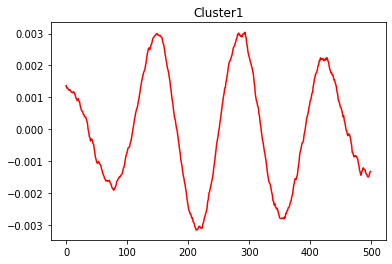

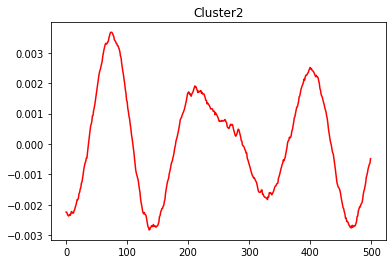

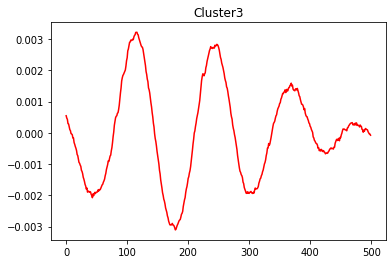

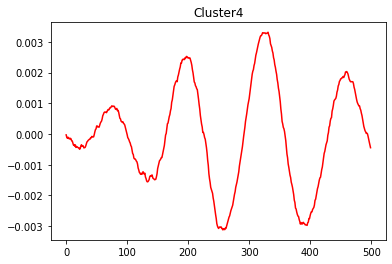

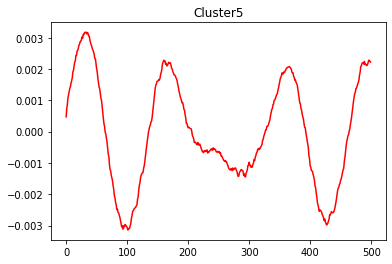

In [ ]:
# load clustering model
km = TimeSeriesKMeans.from_hdf5(clustering_model_filename)
# plot clustering centers
cluster_center_plot(km,cluster_num)

In [ ]:
# create clustered dataset for all five inspections
for ins in ['First','Second','Third','Fourth','Fifth']:
  inputfile = 'Data/Extracted/' + str(MP)+ '_' + ins + '_' + channel + '_' + str(window_length) +'.csv'
  outputfile = 'Data/Clustered/' + 'X_' + ins + '_with_cluster_label_' + clustering_type
  X_df_clustering(inputfile,outputfile,clustering_model_filename,window_length)
# X_df_clustering(inputfile='Data/MP81_First_T16_CBV_500.csv',
#                 outputfile='Clustering_Models/X_train_First_with_cluster_label_euc',
#                 km='Clustering_Models/MP81_500_euc.h5')

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6183 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6373 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6005 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6136 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 7428 1-dimensional timeseries
  '{} 1-dimension

# Tuning

In [ ]:
tuning_train_filename = 'Data/Clustered/MP' + str(MP) + '_X_' + training_inspection + '_with_cluster_label_' + clustering_type
X_tune_train = pd.read_csv(tuning_train_filename)
X_tune_train = X_tune_train.iloc[:,1:502]
# print(X_tune_train)
tuning_train_filename = 'Data/Clustered/MP' + str(MP) + '_X_' + tuning_inspection + '_with_cluster_label_' + clustering_type
X_tune_test = pd.read_csv(tuning_train_filename)
X_tune_test = X_tune_test.iloc[:,1:502]
# print(X_tune_test)

In [ ]:
g_lr_list=[1e-4, 5e-4, 1e-3, 2e-3, 6e-3]
d_lr_list=[5e-5, 1e-4]
tuning_epochs = 50
best_glr, best_dlr = GAN_best_param_searching(g_lr_list,d_lr_list,X_tune_train,X_tune_test, tuning_epochs, MP, cluster_num,window_length)

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print(best_glr)

0.006


In [ ]:
print(best_dlr)

0.0001


In [ ]:
# glr=best_glr
# dlr=best_dlr
glr=0.0001
dlr=0.0001

# Training GAN seperately on each clusters

In [ ]:
# folder to store the discriminator models
folder =10
total_epochs = 500
v_freq = 50

Start of Cluster 1 GAN training
Number of data points in cluster 0 = 293
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7164943814277649, Discriminative Loss: 0.6871452331542969
Epoch #100: Generative Loss: 0.7139418721199036, Discriminative Loss: 0.6877090334892273
Epoch #150: Generative Loss: 0.6990099549293518, Discriminative Loss: 0.6910122632980347
Epoch #200: Generative Loss: 0.6999459862709045, Discriminative Loss: 0.6932671666145325
Epoch #250: Generative Loss: 0.6660789251327515, Discriminative Loss: 0.7017160058021545
Epoch #300: Generative Loss: 0.744864821434021, Discriminative Loss: 0.6866514682769775
Epoch #350: Generative Loss: 0.6526033878326416, Discriminative Loss: 0.7086694240570068
Epoch #400: Generative Loss: 0.6485040783882141, Discriminative Loss: 0.7024842500686646
Epoch #450: Generative Loss: 0.7172920107841492, Discriminative Loss: 0.6963645815849304
Epoch #500: Generative Loss: 0.701859176158905, Discriminative Loss: 0.6780121922492981
Start of Cluster 2 GAN training
Number of data points in cluster 1 = 462
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7040271162986755, Discriminative Loss: 0.6887446641921997
Epoch #100: Generative Loss: 0.6855702996253967, Discriminative Loss: 0.6918764114379883
Epoch #150: Generative Loss: 0.7044675946235657, Discriminative Loss: 0.683225154876709
Epoch #200: Generative Loss: 0.6962347626686096, Discriminative Loss: 0.6961824893951416
Epoch #250: Generative Loss: 0.6963984966278076, Discriminative Loss: 0.6910726428031921
Epoch #300: Generative Loss: 0.6956703662872314, Discriminative Loss: 0.6777942180633545
Epoch #350: Generative Loss: 0.7045820951461792, Discriminative Loss: 0.6998664140701294
Epoch #400: Generative Loss: 0.7005937695503235, Discriminative Loss: 0.6915722489356995
Epoch #450: Generative Loss: 0.6961814165115356, Discriminative Loss: 0.6861374974250793
Epoch #500: Generative Loss: 0.6847111582756042, Discriminative Loss: 0.6999345421791077
Start of Cluster 3 GAN training
Number of data points in cluster 2 = 3646
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7127950191497803, Discriminative Loss: 0.6887831687927246
Epoch #100: Generative Loss: 0.6996498703956604, Discriminative Loss: 0.6903553009033203
Epoch #150: Generative Loss: 0.6903184056282043, Discriminative Loss: 0.6929646134376526
Epoch #200: Generative Loss: 0.6897166967391968, Discriminative Loss: 0.6929703950881958
Epoch #250: Generative Loss: 0.688066303730011, Discriminative Loss: 0.6936984658241272
Epoch #300: Generative Loss: 0.6479537487030029, Discriminative Loss: 0.723867654800415
Epoch #350: Generative Loss: 0.6842089295387268, Discriminative Loss: 0.7144848108291626
Epoch #400: Generative Loss: 0.7617438435554504, Discriminative Loss: 0.6796414256095886
Epoch #450: Generative Loss: 0.6584948897361755, Discriminative Loss: 0.6912853717803955
Epoch #500: Generative Loss: 0.6687256693840027, Discriminative Loss: 0.7040764093399048
Start of Cluster 4 GAN training
Number of data points in cluster 3 = 1028
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7128301858901978, Discriminative Loss: 0.6880012154579163
Epoch #100: Generative Loss: 0.7057410478591919, Discriminative Loss: 0.6890011429786682
Epoch #150: Generative Loss: 0.6971824169158936, Discriminative Loss: 0.6922048330307007
Epoch #200: Generative Loss: 0.6879428029060364, Discriminative Loss: 0.6945711374282837
Epoch #250: Generative Loss: 0.7221747040748596, Discriminative Loss: 0.6934055685997009
Epoch #300: Generative Loss: 0.7127203941345215, Discriminative Loss: 0.6900944709777832
Epoch #350: Generative Loss: 0.6944765448570251, Discriminative Loss: 0.6960013508796692
Epoch #400: Generative Loss: 0.6798739433288574, Discriminative Loss: 0.6900728940963745
Epoch #450: Generative Loss: 0.6811350584030151, Discriminative Loss: 0.6969972848892212
Epoch #500: Generative Loss: 0.6752155423164368, Discriminative Loss: 0.6932771801948547
Start of Cluster 5 GAN training
Number of data points in cluster 4 = 613
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7135030627250671, Discriminative Loss: 0.6863964200019836
Epoch #100: Generative Loss: 0.6975314021110535, Discriminative Loss: 0.6874487996101379
Epoch #150: Generative Loss: 0.7073559165000916, Discriminative Loss: 0.688956618309021
Epoch #200: Generative Loss: 0.6947965621948242, Discriminative Loss: 0.690462589263916
Epoch #250: Generative Loss: 0.6880508661270142, Discriminative Loss: 0.69657301902771
Epoch #300: Generative Loss: 0.696416974067688, Discriminative Loss: 0.6988464593887329
Epoch #350: Generative Loss: 0.6989225149154663, Discriminative Loss: 0.6952924132347107
Epoch #400: Generative Loss: 0.6599546074867249, Discriminative Loss: 0.6939493417739868
Epoch #450: Generative Loss: 0.669959306716919, Discriminative Loss: 0.6927746534347534
Epoch #500: Generative Loss: 0.6853113174438477, Discriminative Loss: 0.6961828470230103


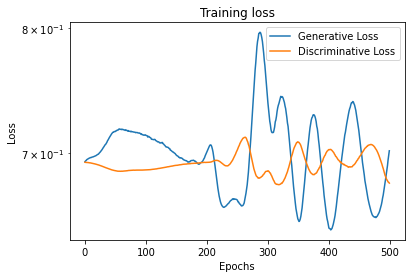

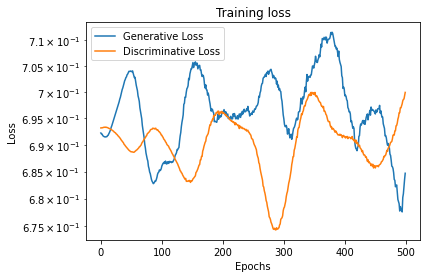

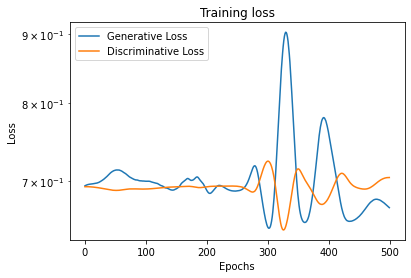

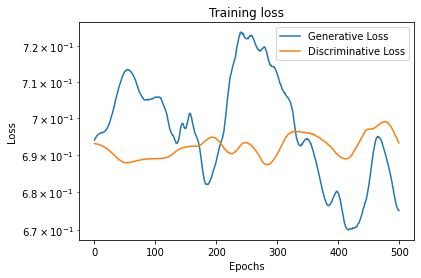

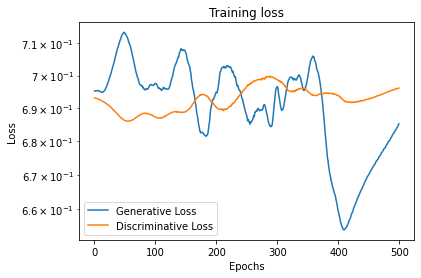

In [ ]:
#folder 10
train_on_clusters(X_tune_train,glr,dlr,cluster_num,window_length,total_epochs,folder,MP, v_freq)

Start of Cluster 1 GAN training
Number of data points in cluster 0 = 293
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7204818725585938, Discriminative Loss: 0.686591625213623
Epoch #100: Generative Loss: 0.7001974582672119, Discriminative Loss: 0.6864364147186279
Epoch #150: Generative Loss: 0.6914002895355225, Discriminative Loss: 0.6911037564277649
Epoch #200: Generative Loss: 0.6904762983322144, Discriminative Loss: 0.6938114166259766
Epoch #250: Generative Loss: 0.6977269649505615, Discriminative Loss: 0.6936176419258118
Epoch #300: Generative Loss: 0.6942456960678101, Discriminative Loss: 0.6935766935348511
Epoch #350: Generative Loss: 0.6896939873695374, Discriminative Loss: 0.6934990286827087
Epoch #400: Generative Loss: 0.6907461285591125, Discriminative Loss: 0.6954153776168823
Epoch #450: Generative Loss: 0.6744548678398132, Discriminative Loss: 0.6947920918464661
Epoch #500: Generative Loss: 0.6861652135848999, Discriminative Loss: 0.7002130746841431
Start of Cluster 2 GAN training
Number of data points in cluster 1 = 462
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.6979004740715027, Discriminative Loss: 0.68825763463974
Epoch #100: Generative Loss: 0.6686347126960754, Discriminative Loss: 0.6920900344848633
Epoch #150: Generative Loss: 0.6393638253211975, Discriminative Loss: 0.704684317111969
Epoch #200: Generative Loss: 0.7324552536010742, Discriminative Loss: 0.7125512361526489
Epoch #250: Generative Loss: 0.8132944703102112, Discriminative Loss: 0.6735660433769226
Epoch #300: Generative Loss: 0.8018017411231995, Discriminative Loss: 0.673688530921936
Epoch #350: Generative Loss: 0.7563139200210571, Discriminative Loss: 0.6893998980522156
Epoch #400: Generative Loss: 0.7189785242080688, Discriminative Loss: 0.6964565515518188
Epoch #450: Generative Loss: 0.7016857266426086, Discriminative Loss: 0.6951392889022827
Epoch #500: Generative Loss: 0.6976161003112793, Discriminative Loss: 0.6941789388656616
Start of Cluster 3 GAN training
Number of data points in cluster 2 = 3646
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7172189354896545, Discriminative Loss: 0.6869112849235535
Epoch #100: Generative Loss: 0.7093670964241028, Discriminative Loss: 0.689304530620575
Epoch #150: Generative Loss: 0.6822214722633362, Discriminative Loss: 0.6934680938720703
Epoch #200: Generative Loss: 0.6848170757293701, Discriminative Loss: 0.6929664611816406
Epoch #250: Generative Loss: 0.6941999793052673, Discriminative Loss: 0.6930623054504395
Epoch #300: Generative Loss: 0.718818187713623, Discriminative Loss: 0.6890925168991089
Epoch #350: Generative Loss: 0.6772081255912781, Discriminative Loss: 0.6907287240028381
Epoch #400: Generative Loss: 0.6854249238967896, Discriminative Loss: 0.6929378509521484
Epoch #450: Generative Loss: 0.6548227667808533, Discriminative Loss: 0.6949529051780701
Epoch #500: Generative Loss: 0.76490318775177, Discriminative Loss: 0.6839067935943604
Start of Cluster 4 GAN training
Number of data points in cluster 3 = 1028
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7166907787322998, Discriminative Loss: 0.6866089105606079
Epoch #100: Generative Loss: 0.7039090991020203, Discriminative Loss: 0.6891201138496399
Epoch #150: Generative Loss: 0.6973300576210022, Discriminative Loss: 0.6908532381057739
Epoch #200: Generative Loss: 0.6894752383232117, Discriminative Loss: 0.6961875557899475
Epoch #250: Generative Loss: 0.7223020792007446, Discriminative Loss: 0.6875421404838562
Epoch #300: Generative Loss: 0.6752822995185852, Discriminative Loss: 0.6994274854660034
Epoch #350: Generative Loss: 0.6931686401367188, Discriminative Loss: 0.6916263103485107
Epoch #400: Generative Loss: 0.6877980828285217, Discriminative Loss: 0.6993281245231628
Epoch #450: Generative Loss: 0.7507993578910828, Discriminative Loss: 0.6840583086013794
Epoch #500: Generative Loss: 0.6925396919250488, Discriminative Loss: 0.691550076007843
Start of Cluster 5 GAN training
Number of data points in cluster 4 = 613
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7110427618026733, Discriminative Loss: 0.6877630949020386
Epoch #100: Generative Loss: 0.704636812210083, Discriminative Loss: 0.6909970045089722
Epoch #150: Generative Loss: 0.7195065021514893, Discriminative Loss: 0.6866544485092163
Epoch #200: Generative Loss: 0.6935538053512573, Discriminative Loss: 0.6955663561820984
Epoch #250: Generative Loss: 0.6849930286407471, Discriminative Loss: 0.691956639289856
Epoch #300: Generative Loss: 0.6813616156578064, Discriminative Loss: 0.6941965222358704
Epoch #350: Generative Loss: 0.6856138706207275, Discriminative Loss: 0.6933119893074036
Epoch #400: Generative Loss: 0.6819063425064087, Discriminative Loss: 0.6932401657104492
Epoch #450: Generative Loss: 0.6834329962730408, Discriminative Loss: 0.692919135093689
Epoch #500: Generative Loss: 0.690274178981781, Discriminative Loss: 0.6931918263435364


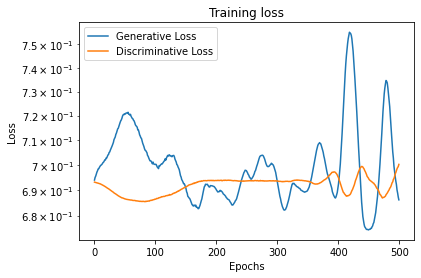

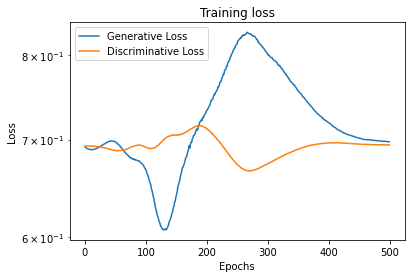

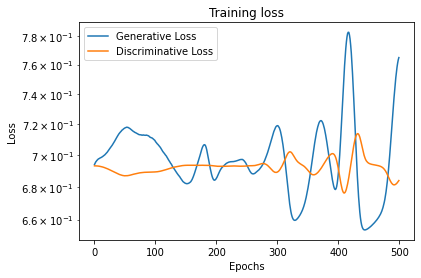

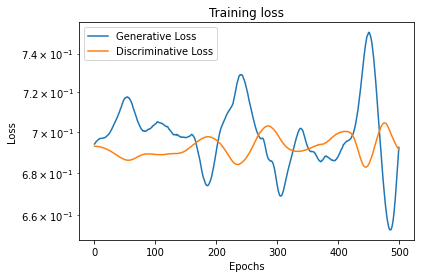

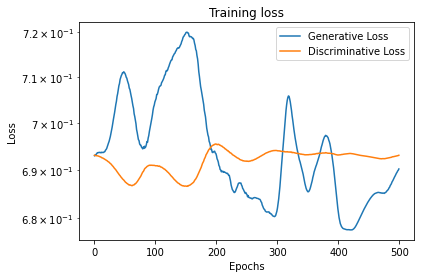

In [ ]:
#folder 4
train_on_clusters(X_tune_train,glr,dlr,cluster_num,window_length,total_epochs,folder,MP, v_freq)

Start of Cluster 1 GAN training
Number of data points in cluster 0 = 293
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 3.7308883666992188, Discriminative Loss: 0.3541349470615387
Epoch #100: Generative Loss: 4.624765396118164, Discriminative Loss: 0.3429415225982666
Epoch #150: Generative Loss: 5.072805404663086, Discriminative Loss: 0.33663707971572876
Start of Cluster 2 GAN training
Number of data points in cluster 1 = 462
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 4.408336639404297, Discriminative Loss: 0.3506784737110138
Epoch #100: Generative Loss: 4.88679313659668, Discriminative Loss: 0.3408222794532776
Epoch #150: Generative Loss: 5.14306116104126, Discriminative Loss: 0.333795428276062
Start of Cluster 3 GAN training
Number of data points in cluster 2 = 3646
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 4.777711391448975, Discriminative Loss: 0.34560632705688477
Epoch #100: Generative Loss: 5.192315101623535, Discriminative Loss: 0.337575227022171
Epoch #150: Generative Loss: 5.526494026184082, Discriminative Loss: 0.33098819851875305
Start of Cluster 4 GAN training
Number of data points in cluster 3 = 1028
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 4.024860858917236, Discriminative Loss: 0.3512862026691437
Epoch #100: Generative Loss: 4.747056007385254, Discriminative Loss: 0.3418427109718323
Epoch #150: Generative Loss: 5.1750898361206055, Discriminative Loss: 0.3355848789215088
Start of Cluster 5 GAN training
Number of data points in cluster 4 = 613
(None, 500)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 4.490999221801758, Discriminative Loss: 0.3475675582885742
Epoch #100: Generative Loss: 4.903650283813477, Discriminative Loss: 0.33852800726890564
Epoch #150: Generative Loss: 5.363028049468994, Discriminative Loss: 0.3317010998725891


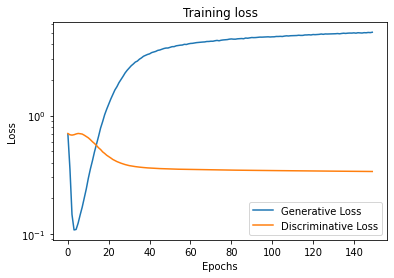

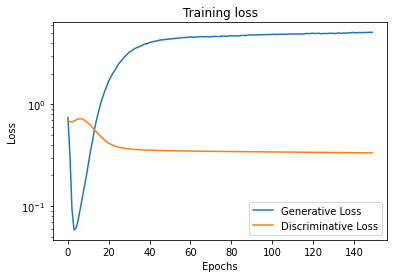

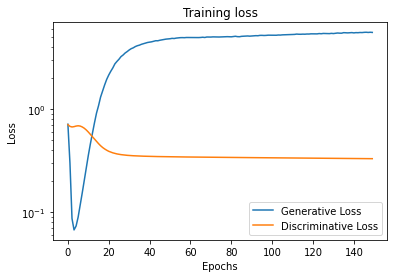

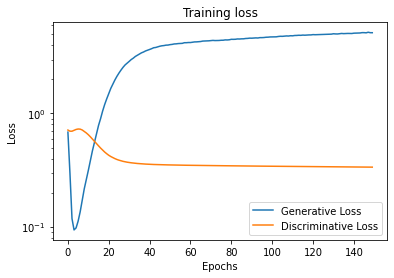

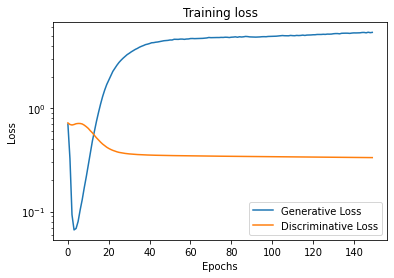

In [ ]:
# folder 3
train_on_clusters(X_tune_train,glr,dlr,cluster_num,window_length,total_epochs,folder,MP, v_freq)

# Model selection


In [ ]:
# model selection based on the validation inspection
best_epoch = D_model_selection(X_tune_test, total_epochs, v_freq, folder, MP) # folder 10
print(best_epoch)

epoch 49 : 6276.0 anomalies
epoch 99 : 5478.0 anomalies
epoch 149 : 2143.0 anomalies
epoch 199 : 1101.0 anomalies
epoch 249 : 1677.0 anomalies
epoch 299 : 6177.0 anomalies
epoch 349 : 6088.0 anomalies
epoch 399 : 4131.0 anomalies
epoch 449 : 876.0 anomalies
epoch 499 : 668.0 anomalies
499


In [ ]:
# model selection based on the validation inspection
best_epoch = D_model_selection(X_tune_test, total_epochs, v_freq, folder, MP) # folder 10
print(best_epoch)

epoch 49 : 6282.0 anomalies
epoch 99 : 6283.0 anomalies
epoch 149 : 6283.0 anomalies
epoch 199 : 749.0 anomalies
epoch 249 : 95.0 anomalies
epoch 299 : 88.0 anomalies
epoch 349 : 94.0 anomalies
epoch 399 : 101.0 anomalies
epoch 449 : 109.0 anomalies
epoch 499 : 140.0 anomalies
299


In [ ]:
# model selection based on the validation inspection
best_epoch = D_model_selection(X_tune_test, total_epochs, v_freq, folder, MP) # folder 5
print(best_epoch)

epoch 49 : 5851.0 anomalies
epoch 99 : 4818.0 anomalies
epoch 149 : 2674.0 anomalies
epoch 199 : 5664.0 anomalies
epoch 249 : 4956.0 anomalies
epoch 299 : 2026.0 anomalies
epoch 349 : 1743.0 anomalies
epoch 399 : 757.0 anomalies
epoch 449 : 1382.0 anomalies
epoch 499 : 949.0 anomalies
399


In [ ]:
# model selection based on the validation inspection
best_epoch = D_model_selection(X_tune_test, total_epochs, v_freq, folder, MP) # folder 4

epoch 49 : 6182.0 anomalies
epoch 99 : 5927.0 anomalies
epoch 149 : 1801.0 anomalies
epoch 199 : 1504.0 anomalies
epoch 249 : 5344.0 anomalies
epoch 299 : 4503.0 anomalies
epoch 349 : 482.0 anomalies
epoch 399 : 1471.0 anomalies
epoch 449 : 1259.0 anomalies
epoch 499 : 4425.0 anomalies


In [ ]:
print(best_epoch)

499


# Test


predicted anomalies
[1511 3570 3998 4131]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


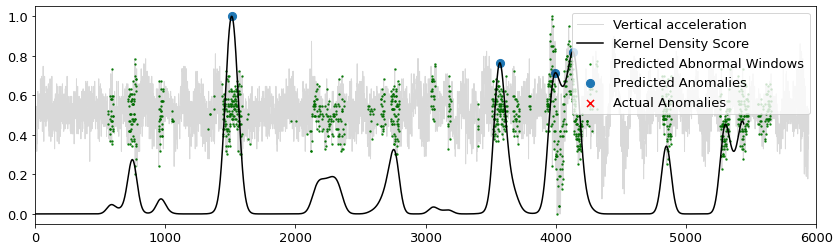

predicted anomalies
[3609 4022 4170]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

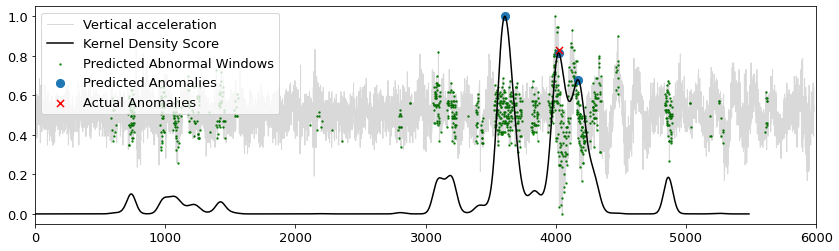

predicted anomalies
[3801 3944 4648]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

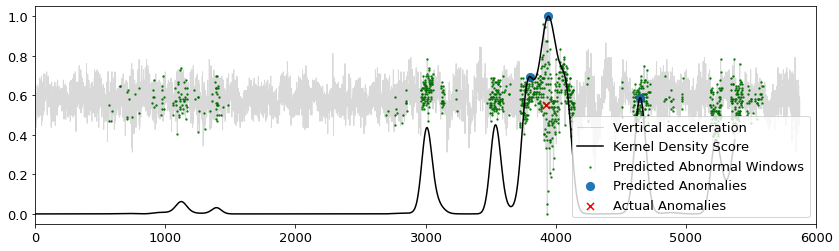

In [ ]:
# test on labeled (Folder #10: epochs=500, interval=50)
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4072 4508]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


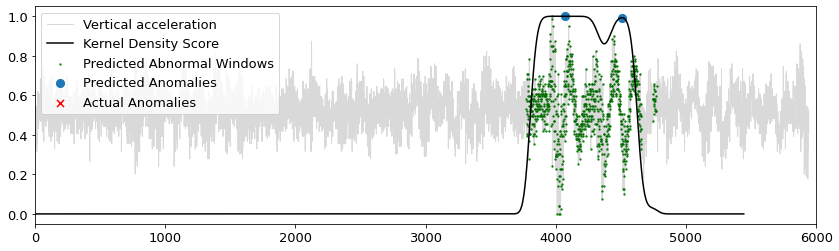

predicted anomalies
[4280]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

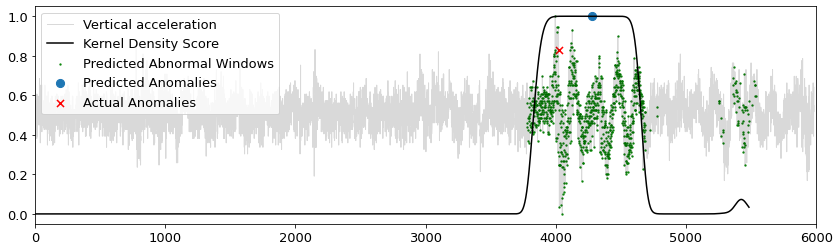

predicted anomalies
[4092]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

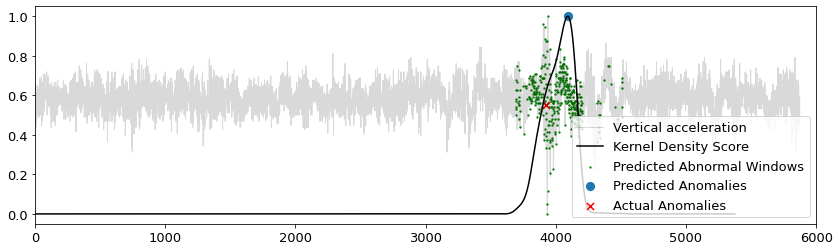

In [ ]:
# test on labeled (Folder #10: epochs=500, interval=50)
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4061]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


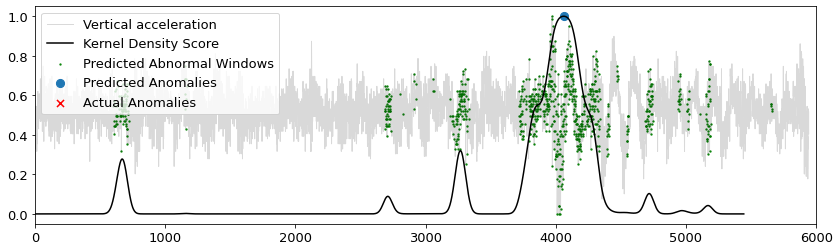

predicted anomalies
[2766 3866 4074]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

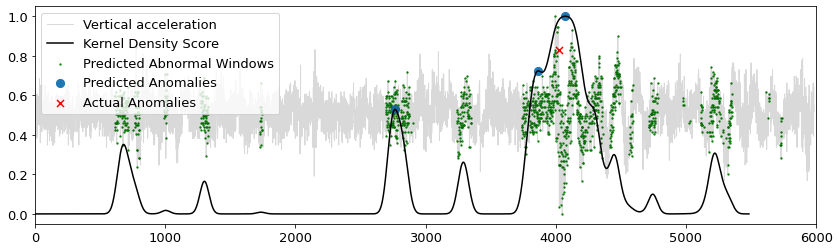

predicted anomalies
[3924]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

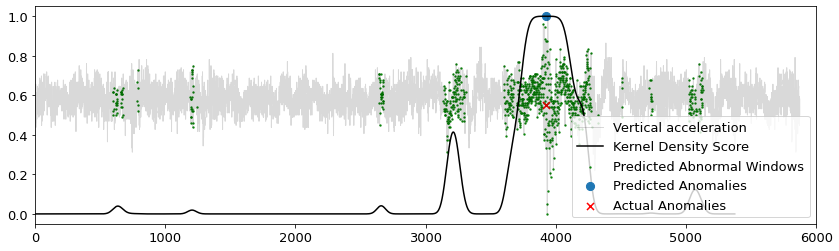

In [ ]:
# test on labeled (Folder #5: epochs=500, interval=50)
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4064]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


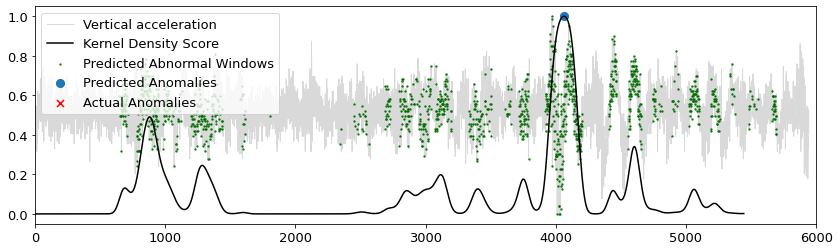

predicted anomalies
[ 874 4076 5470]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

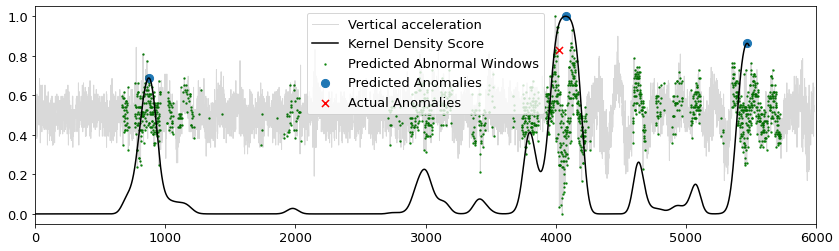

predicted anomalies
[3920]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

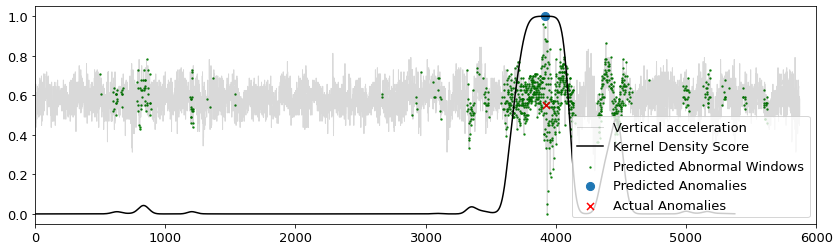

In [ ]:
# test on labeled (Folder #4: epochs=500, interval=50)  
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4190]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


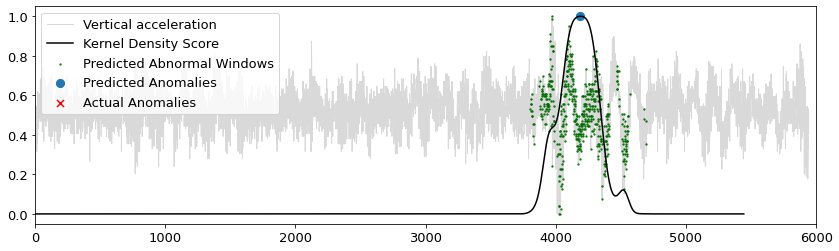

predicted anomalies
[4221]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

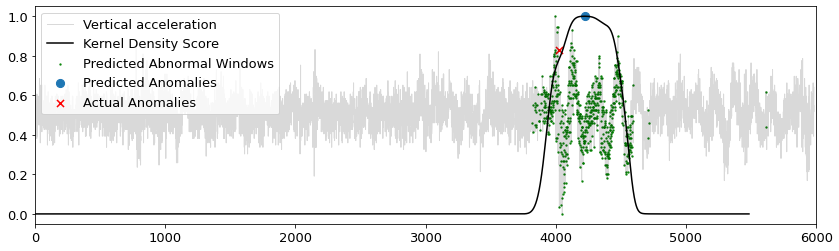

predicted anomalies
[4115]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

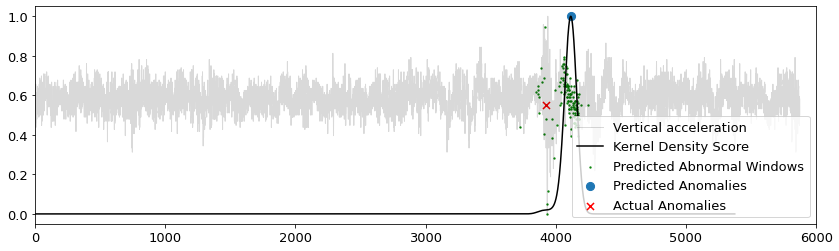

In [ ]:
# test on labeled (Folder #3: epochs=150, interval=50)
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4115]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


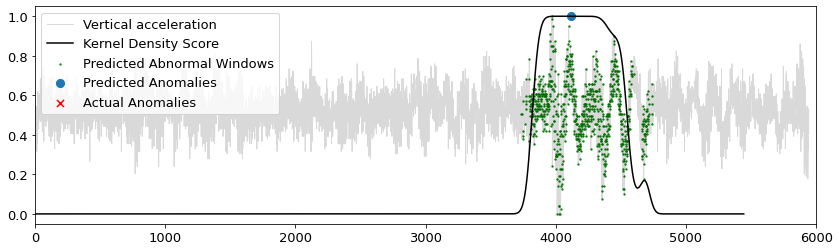

predicted anomalies
[4217]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

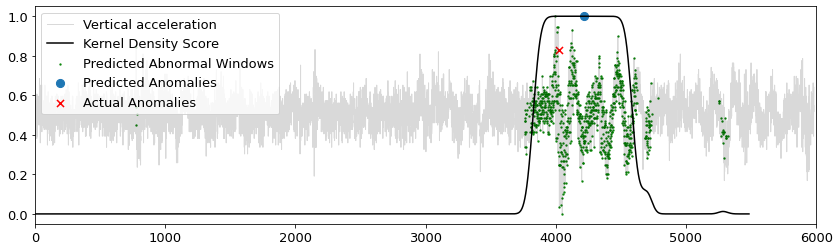

predicted anomalies
[4076]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

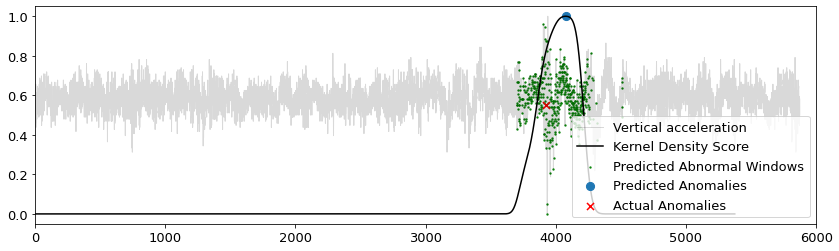

In [ ]:
# test on labeled (Folder #2: epochs=150, interval=50)
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4241]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

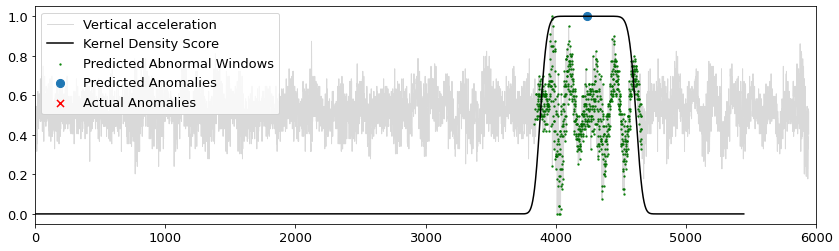

predicted anomalies
[4251]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

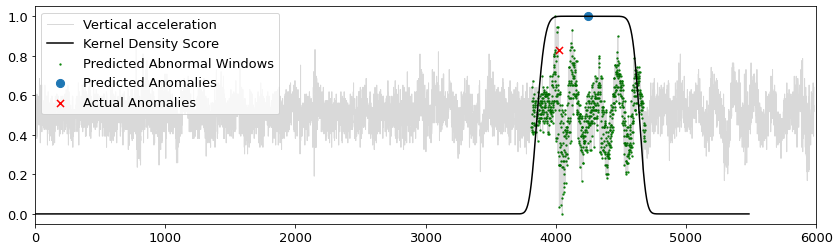

predicted anomalies
[4016]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

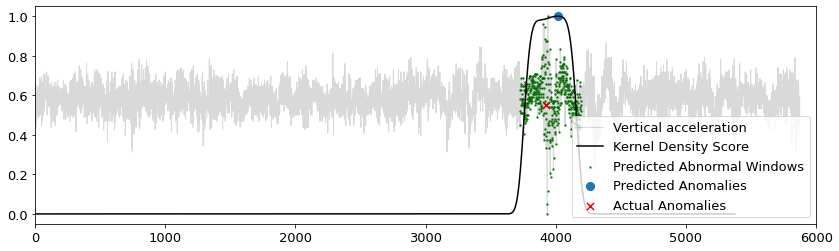

In [ ]:
# test on labeled (Folder #1: epochs=150, interval=50)
testing_ins =['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)

predicted anomalies
[4007 4129 4606]
actual anoamlies:
[]


<Figure size 432x288 with 0 Axes>

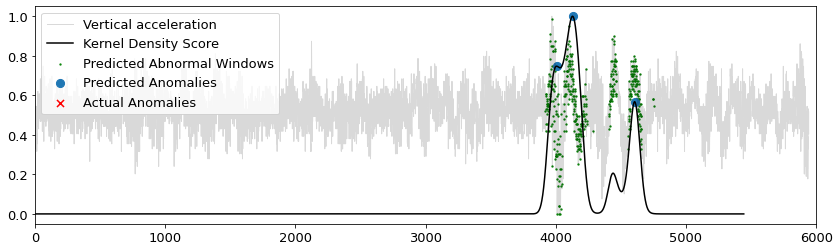

predicted anomalies
[4168]
actual anoamlies:
[4022]


<Figure size 432x288 with 0 Axes>

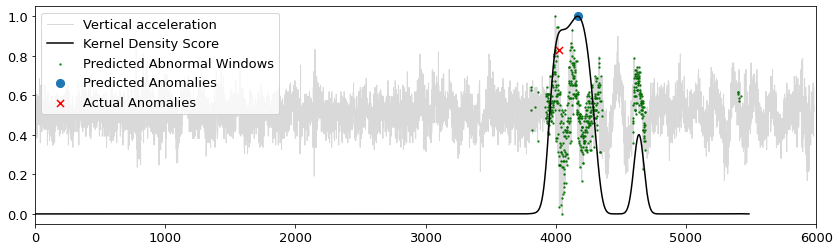

predicted anomalies
[4086]
actual anoamlies:
[3927]


<Figure size 432x288 with 0 Axes>

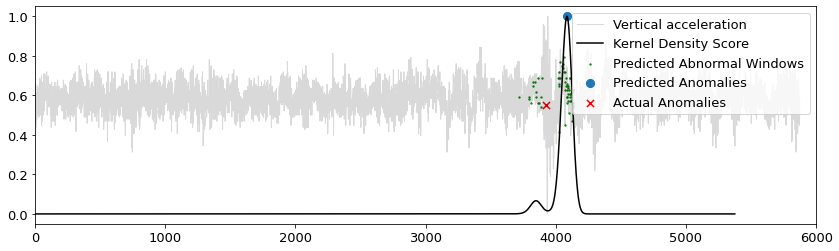

In [ ]:
# test on labeled (Folder #0: epochs=80, interval=5)
testing_ins = ['First','Second','Fourth']
for test in testing_ins:
  X_test_filename_cluster = 'Data/Clustered/MP' + str(MP)+ '_X_' + test + '_with_cluster_label_' + clustering_type

  X_test_filename_label = 'Data/Extracted/MP' + str(MP) + '_' + test + '_' + channel+ '_' + str (window_length) +'.csv'
  profile_filename = 'Data/Original/MP' + str(MP) + '_'  + channel+ '_' + test +'.csv'
  
  X_test = pd.read_csv(X_test_filename_cluster)
  X_test = X_test.iloc[:,1:502]
  testing = pd.read_csv(X_test_filename_label)
  y_test = testing['label']
  evaluate_D(X_test,y_test,best_epoch, MP, cluster_num, window_length,folder,profile_filename)